<a href="https://colab.research.google.com/github/ATOMconsortium/AMPL/blob/master/atomsci/ddm/examples/tutorials/01_Exploring_Target_Activity_ExcapeDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring HTR3A protein target activity data from ExcapeDB

# Scope of the tutorial
*   Input data from Excape dataset for HTR3A protein target
*   AMPL will be used to accomplish the following steps: 
  *   Standardize SMILES string
  *   Clean the data (look for duplicates, average the assay data, cluster the compounds etc.)
  *   Carry out some Exploratory Data Analysis (Chemical space exploration; PCA etc.) 
  *   Save the final dataset for modeling



# Time to run the notebook on COLAB-Pro: ~ 3 minutes

# Protein target (HTR3A) information

The HTR3A target binding data was downloaded from ExcapeDB (https://solr.ideaconsult.net/search/excape/)

Please refer to the ExCAPE-DB publication (https://pubmed.ncbi.nlm.nih.gov/28316655/) for details about the database 

Here are some details about HTR3A gene (taken from RefSeq NCBI)


*   Proteins belongs to GPCR superfamily
*   HTR3a is a receptor for Serotonin, a biogenic hormone that functions as a neurotransmitter
*   HTR3A (also the name of the gene) encodes the subunit of the type 3 receptor for neurotransmitter 
*   Herteromeric combination of subunit A and B (HTR3B) is needed for full function. 
*   Different alternately spliced transcript variant forms for this gene are available.  

Diseases associated with HTR3A include Irritable Bowel Syndrome and Motion Sickness.

## Additional information about HTR3A gene:

**Gene location:** Chromosome 11
**Exon count:** 10

mRNA and protein information for its three transcripts:

*   NM_000869.6 → NP_000860.3 
*   NM_001161772.3 → NP_001155244.1
*   NM_213621.4 → NP_998786.3 

## Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings
If you have access to COLAB-Pro (commercial/not-free), please change your runtime settings to use GPU and high-memory,

```Runtime --> Change Runtime Type --> GPU with high-RAM```

If you are not a paid COLAB-Pro customer, you can still choose GPU, with standard-RAM.

In [1]:
!date # starting time

Wed Sep 15 15:27:41 UTC 2021


## Install AMPL


In [ ]:
! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.34.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

In [4]:
!date

Wed Sep 15 15:28:47 UTC 2021


## Exploring target activity data from selected database
## Data source = ExcapeDB
## Target activity for the receptor HTR3A

In [5]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')
import json
import requests

In [6]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd

# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

# Define the target name

In [7]:
target_name='HTR3A'

# Download the dataset

In [8]:
import io
url = 'https://raw.githubusercontent.com/ATOMconsortium/AMPL/Tutorials/atomsci/ddm/examples/tutorials/datasets/Excape_HTR3A.tsv'
download = requests.get(url).content

In [9]:
# Reading the downloaded content and turning it into a pandas dataframe
orig_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep='\t', header=0 )

In [10]:
orig_df.head(3)

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES
0,AATPYXMXFBBKFO-KARVIEMNNA-N,CHEMBL526307,3359,N,1.00,chembl20,565951,9606,HTR3A,2102,InChI=1/C14H17IN4O2/c1-7(2)8-4-11(20-3)9(15)5-...,C=1C(=C(OC2=CN=C(N=C2N)N)C=C(C1OC)I)C(C)C
1,ABIDZKZAFOTHFB-CCUGXXBONA-N,CHEMBL1271790,3359,A,8.17,chembl20,674333,9606,HTR3A,2102,InChI=1/C21H28N4O3/c1-13-11-27-12-14(2)25(13)2...,C1C2CCN(C1)C[C@H]2NC(C3=C4N=C(OC4=CC=C3)N5[C@H...
2,ABSDJNLAUZQHJY-UHFFFAOYNA-N,CHEMBL2205048,3359,A,7.21,chembl20,880265,9606,HTR3A,2102,InChI=1/C17H20N2OS/c1-20-14-5-4-6-15(13-14)21-...,N1(CCNCC1)C=2C(=CC=CC2)SC=3C=C(C=CC3)OC


We are interested in modeling human HTR3A gene target binding. Let us confirm our binding data contains only the gene of our interest.

In [11]:
orig_df.Gene_Symbol.value_counts()

HTR3A    649
Name: Gene_Symbol, dtype: int64

## Let us choose a meaningful output **name** to save out data for later AMPL use

In [12]:
ofile=target_name+'_excape.csv'

## Load target data into a pandas data frame

In [13]:
#show number of rows in data frame and number of columns
print(orig_df.shape)

# show column names
display(orig_df.columns)

(649, 12)


Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'InChI', 'SMILES'],
      dtype='object')

In [14]:
orig_df.describe()

,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,649.000000,645.000000,6.490000e+02,649.000000,649.0
mean,16215.274268,6.983770,6.633640e+05,9715.318952,2102.0
std,27698.741204,1.505524,2.569910e+05,207.728422,0.0
min,3359.000000,1.000000,3.123000e+03,9606.000000,2102.0
25%,3359.000000,5.800000,5.369680e+05,9606.000000,2102.0
50%,3359.000000,7.161150,6.525690e+05,9606.000000,2102.0
75%,3359.000000,8.140000,8.059070e+05,9606.000000,2102.0
max,79246.000000,10.500000,1.350972e+06,10116.000000,2102.0


## Let us fill any missing values with 0 to infer a censored value

In [15]:
save_df=orig_df

# It is a good idea to make them zero, so that it will be easier to deal 
# with it rather than NAs
save_df['pXC50'] = save_df['pXC50'].fillna(0)

# `get.smiles_escape_data`
We are ready to call our first AMPL function, `get.smiles_escape_data` What does get.smiles_excape_data function do? 

*   Expects a 'pXC50' column and the target_name(s) as a list 
*   Applies **dropna** on `pXC50` column
*   Standardizes by calling **struct_utils.base_smiles_from_smiles** and converts **SMILES** column and writes it out as a new column called **rdkit_smiles** 
        * base_smiles_from_smiles(orig_smiles, useIsomericSmiles=True, removeCharges=False, workers=1)
*  Function will return a list that contains a DF (with added column, **rdkit_smiles** and a list of InChiKey

In [16]:
slst,klst = dcf.get_smiles_excape_data(save_df, [target_name])
save_smiles_df = slst[0]

HTR3A distinct compounds = only 605
(649, 13)
605


In [17]:
print(save_smiles_df.shape)
save_smiles_df.head(3)


(649, 13)


,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles
0,AATPYXMXFBBKFO-KARVIEMNNA-N,CHEMBL526307,3359,N,1.00,chembl20,565951,9606,HTR3A,2102,InChI=1/C14H17IN4O2/c1-7(2)8-4-11(20-3)9(15)5-...,C=1C(=C(OC2=CN=C(N=C2N)N)C=C(C1OC)I)C(C)C,COc1cc(C(C)C)c(Oc2cnc(N)nc2N)cc1I
1,ABIDZKZAFOTHFB-CCUGXXBONA-N,CHEMBL1271790,3359,A,8.17,chembl20,674333,9606,HTR3A,2102,InChI=1/C21H28N4O3/c1-13-11-27-12-14(2)25(13)2...,C1C2CCN(C1)C[C@H]2NC(C3=C4N=C(OC4=CC=C3)N5[C@H...,C[C@H]1COC[C@H](C)N1c1nc2c(C(=O)N[C@@H]3CN4CCC...
2,ABSDJNLAUZQHJY-UHFFFAOYNA-N,CHEMBL2205048,3359,A,7.21,chembl20,880265,9606,HTR3A,2102,InChI=1/C17H20N2OS/c1-20-14-5-4-6-15(13-14)21-...,N1(CCNCC1)C=2C(=CC=CC2)SC=3C=C(C=CC3)OC,COc1cccc(Sc2ccccc2N2CCNCC2)c1


For testing, sometimes it is easier to create and work with a smaller dataset.  
A template code is shown below, if you decide to use a smaller subset

In [18]:
# comment the following two code lines in system with memory constraints or for testing
# make a copy 
# save_smiles_df_copy = save_smiles_df
# save_smiles_df = save_smiles_df.sample(frac=0.5, random_state=1)

In [19]:
## Save this newly created file that contains the RDKIT conanonical SMILES
save_smiles_df.to_csv(ofile,index=False)

# We are ready to curate the data

Let us summarize the data first


Post-processing dataset

Total Number of results = 649
dataset mean = 6.940726964560859 NM
dataset stdev = 1.5974425828247447 NM
dataset max = 10.5 NM
dataset min = 0.0 NM



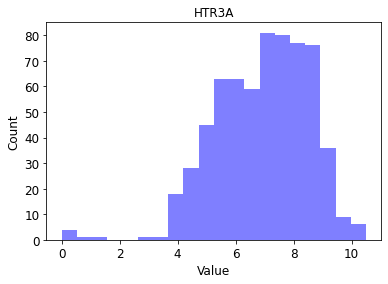

In [20]:
# Our outcome is pXC50 
column = 'pXC50'

# num_bins wil decide how many bins for creating histogram plot
num_bins = 20

# Ue the target_name as the title for the plot 
title = target_name

# Outcome data units (nanomolar = nm = $1 x 10^-9$ M )
units = 'NM'

# filepath, in this case, current dir
filepath = ""

# save_smiles_df was defined earlier
data=save_smiles_df

# call AMPL function (mouse over the function call and view source to see the code)
# The curate_data.summarize_data will summarize the data 
# output will be: 
# Total Number of results (data rows)
#   dataset mean: (mean of pXC50)
#   dataset stdev: (sd of pXC50)
#   dataset max: max value of data
#   dataset min: min value of data
curate_data.summarize_data(column, num_bins, title, units, filepath, data)

In [21]:
print(data.columns)
print(ofile)

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'InChI', 'SMILES', 'rdkit_smiles'],
      dtype='object')
HTR3A_excape.csv


In [22]:
data.rename( columns={ "Ambit_InchiKey" : "compound_id" }, inplace=True)
data.head(5)
curated_file = ofile

In [23]:
# column: Response values column
column = 'pXC50'

# tolerance: Percentage of individual respsonse values allowed to differ from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response 
# value. 
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# column that will be averaged ; smiles_col; used to find the replicates

In [24]:
unique_smiles = data.groupby(smiles_col)
VALUE_NUM_mean = unique_smiles[column].mean()
VALUE_NUM_std = unique_smiles[column].std()

In [25]:
data.columns

Index(['compound_id', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'InChI', 'SMILES', 'rdkit_smiles'],
      dtype='object')

In [26]:
print(VALUE_NUM_mean)

rdkit_smiles
Brc1ccc(C[N+]23CC[C@H]4[C@@H]2C[C@H]2C(=CCO[C@@H]5[C@H]2[C@@H]4N(c2ccccc2)[C@@H]2OCC=C4C[N+]6(Cc7ccc(Br)cc7)CC[C@]78c9ccccc9N5[C@H]7[C@H]2[C@H]4C[C@@H]86)C3)cc1    5.244130
Brc1ccc2oc(N3CCN4CCC3CC4)nc2c1                                                                                                                                      7.770000
Brc1cnc2nc(N3CCN4CCC3CC4)oc2c1                                                                                                                                      6.071695
C/C=C/C[N+]12CC[C@H]3[C@@H]1C[C@H]1C(=CCO[C@@H]4[C@H]1[C@@H]3N(c1ccccc1)[C@@H]1OCC=C3C[N+]5(C/C=C/C)CC[C@]67c8ccccc8N4[C@H]6[C@H]1[C@H]3C[C@@H]75)C2                4.820000
C/N=C1\N(C)C(=O)/C(=C\c2c[nH]c3ccc(Br)cc23)N1C                                                                                                                      5.581040
                                                                                                                          

In [27]:
curated_df = curate_data.average_and_remove_duplicates(column, 
                                                       tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)
# curated_file = os.path.join(working_dir, ofile)
## discard out of range values
curated_df=curated_df[curated_df['VALUE_NUM_mean']>2]
curated_df.to_csv(curated_file, index=False)

Bad duplicates removed from dataset
Dataframe size (649, 17)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, pXC50, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (605, 17)
New column created with averaged values:  VALUE_NUM_mean


## Note this includes the compounds discarded by measurement variation and out of range values

In [28]:
curated_df['Remove_BadDuplicate'].value_counts()

0    599
Name: Remove_BadDuplicate, dtype: int64

In [29]:
compound_id='rdkit_smiles'
reject=data[~data[compound_id].isin(curated_df[compound_id])]
reject

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles
0,AATPYXMXFBBKFO-KARVIEMNNA-N,CHEMBL526307,3359,N,1.00,chembl20,565951,9606,HTR3A,2102,InChI=1/C14H17IN4O2/c1-7(2)8-4-11(20-3)9(15)5-...,C=1C(=C(OC2=CN=C(N=C2N)N)C=C(C1OC)I)C(C)C,COc1cc(C(C)C)c(Oc2cnc(N)nc2N)cc1I
169,GVOCXQUIZNWEMU-YAQRNVERNA-N,14712103,3359,N,0.00,pubchem,616534,9606,HTR3A,2102,InChI=1/C12H15N3/c1-2-4-11(5-3-1)8-13-7-6-12-9...,N(CCC=1NC=NC1)CC2=CC=CC=C2,c1ccc(CNCCc2cnc[nH]2)cc1
321,NECSKBYJMMVETP-UHFFFAOYNA-N,CHEMBL3233402,3359,N,1.29,chembl20,1337830,9606,HTR3A,2102,InChI=1/C31H36N4O2/c1-32-29(36)31(26-14-6-2-7-...,C1(C(N(C(N1CCCCCN2CCN(CC2)C3=CC=CC=C3)=O)C)=O)...,CN1C(=O)N(CCCCCN2CCN(c3ccccc3)CC2)C(c2ccccc2)(...
331,NRJJRVIMKKANAW-UHFFFAOYNA-N,1408942,3359,N,0.00,pubchem,616534,9606,HTR3A,2102,InChI=1/C15H18N4/c1-18-7-9-19(10-8-18)15-11-14...,N1(CCN(CC1)C)C=2N=CN=C(C2)C3=CC=CC=C3,CN1CCN(c2cc(-c3ccccc3)ncn2)CC1
344,OGPREQIZGSIMHW-JLGFQASFNA-N,71459241,3359,N,0.00,pubchem,709378,9606,HTR3A,2102,"InChI=1/C16H28N4O/c1-16(2,3)13-12-14(19-18-13)...",O=C(NC1=NNC(C(C)(C)C)=C1)CCCN2CCCCC2,CC(C)(C)c1cc(NC(=O)CCCN2CCCCC2)n[nH]1
526,VJEBGMIAGKMECI-FNGIMCLKNA-N,76316933,3359,N,0.00,pubchem,643471,9606,HTR3A,2102,InChI=1/C27H32N8O4/c1-33-18-7-6-8-19(33)16-17(...,O=C(NC1C[C@H]2N([C@@H](C1)CCC2)C)C3=NN(C4=C3C=...,CN1[C@H]2CCC[C@@H]1CC(NC(=O)c1nn(CCCCNc3ccc([N...


## save rejected molecules for further examination

In [30]:
print("Number of discarded compounds",reject[compound_id].nunique())
ofile=target_name+'.reject_check.csv'
reject.to_csv(ofile,index=False)

Number of discarded compounds 6


(0.0, 12.0)

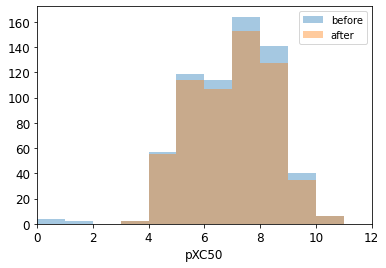

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()

# This will be our before curation
before=data["pXC50"]

# current curated dataframe will not include any out of range values
after=curated_df["pXC50"]

sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')
plt.legend()
ax.set_xlim([0, 12])

## Let us cluster the compounds to explore the chemical space


Project compounds into two dimensions with UMAP and Tanimoto similiarty

1.   Cluster compounds by Tanimoto similarity
2.   Repeat steps 1 and 2 with Maximum Common Substructure distance when dataset size is below # threshold (default < 300)

See documentation here:
 https://ampl.readthedocs.io/en/latest/pipeline.html?highlight=diversity_plots#pipeline.diversity_plots.diversity_plots

 </li>

# Save output from clustering heatmap to image and upload to presentation

In [32]:
ifile=target_name+'_excape.csv'

# Plot self similarity (Tanimoto) within dataset and show distribution of distances between compounds in dataset for nearest neighbor.

## Save  distribution plot as an image.

We will be calling dp.diversity_function from AMPL in the following code chunk. For AMPL function explanations, 
please consult AMPL documentation here, https://ampl.readthedocs.io/en/latest/pipeline.html?highlight=diversity_plots#pipeline.diversity_plots.diversity_plots 

## Here is a brief explanation of `dp` function: 

### The AMPL function will calculate diversity profile for the data. 

### Input Args:


*   **dset_key:** : Name of the input data variable 
*   **datastore** : 
*   **id_col**    : Ambit_InchiKey, it is a chemical identifier for the compound or drug molecules. Please check here for a detailed explanation of InChiKey, https://en.wikipedia.org/wiki/International_Chemical_Identifier#:~:text=%2B%2Fm0%2Fs1-,InChIKey,hashed%20counterpart%20of%20standard%20InChI. In this case, Excape is using InChiKey generated from Ambit
*   **response_col**: Outcome column, in out case it is pXC50

## `dp.diversity_plots` function

*    Computes Fingerprints 
*    If the number of compounds are > 300, it will compute Fingerprints and use it to compute Tanimoto distance matrix. plot the distances using UMAP projection and cluster (complete cluster method will be used) the distances to create a heatmap
*   If the number of compounds are < 300, MCS (Maximum Common Substructure) will be in addition the above step. 


## Helpful links

* Tanimoto 
    * https://en.wikipedia.org/wiki/Jaccard_index
    * https://en.wikipedia.org/wiki/Chemical_similarity
* UMAP
    * https://pair-code.github.io/understanding-umap/
* MCS
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2718661/ 

In [33]:
x_del = pd.read_csv(ifile)

In [34]:
x_del.columns

Index(['compound_id', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'InChI', 'SMILES', 'rdkit_smiles', 'VALUE_NUM_mean',
       'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate'],
      dtype='object')

Canonicalizing 599 molecules...
Done
Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


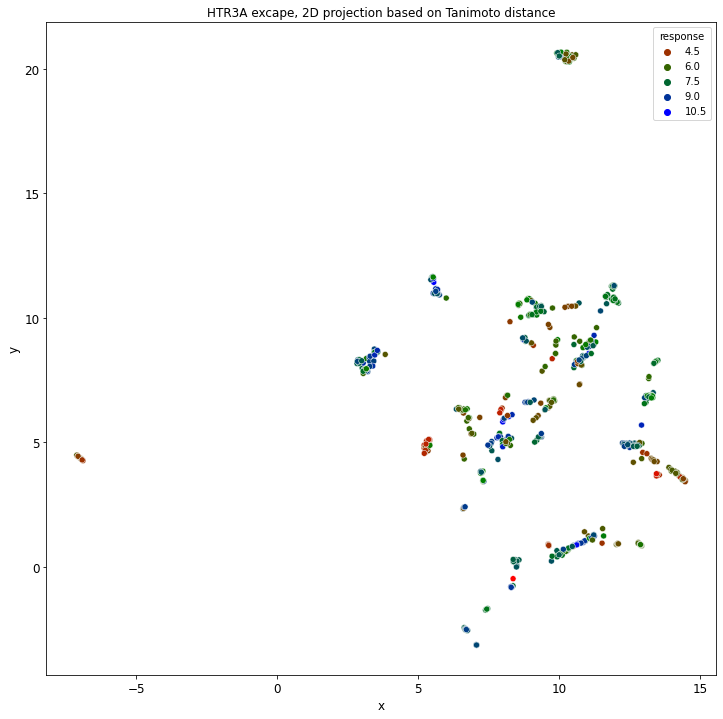

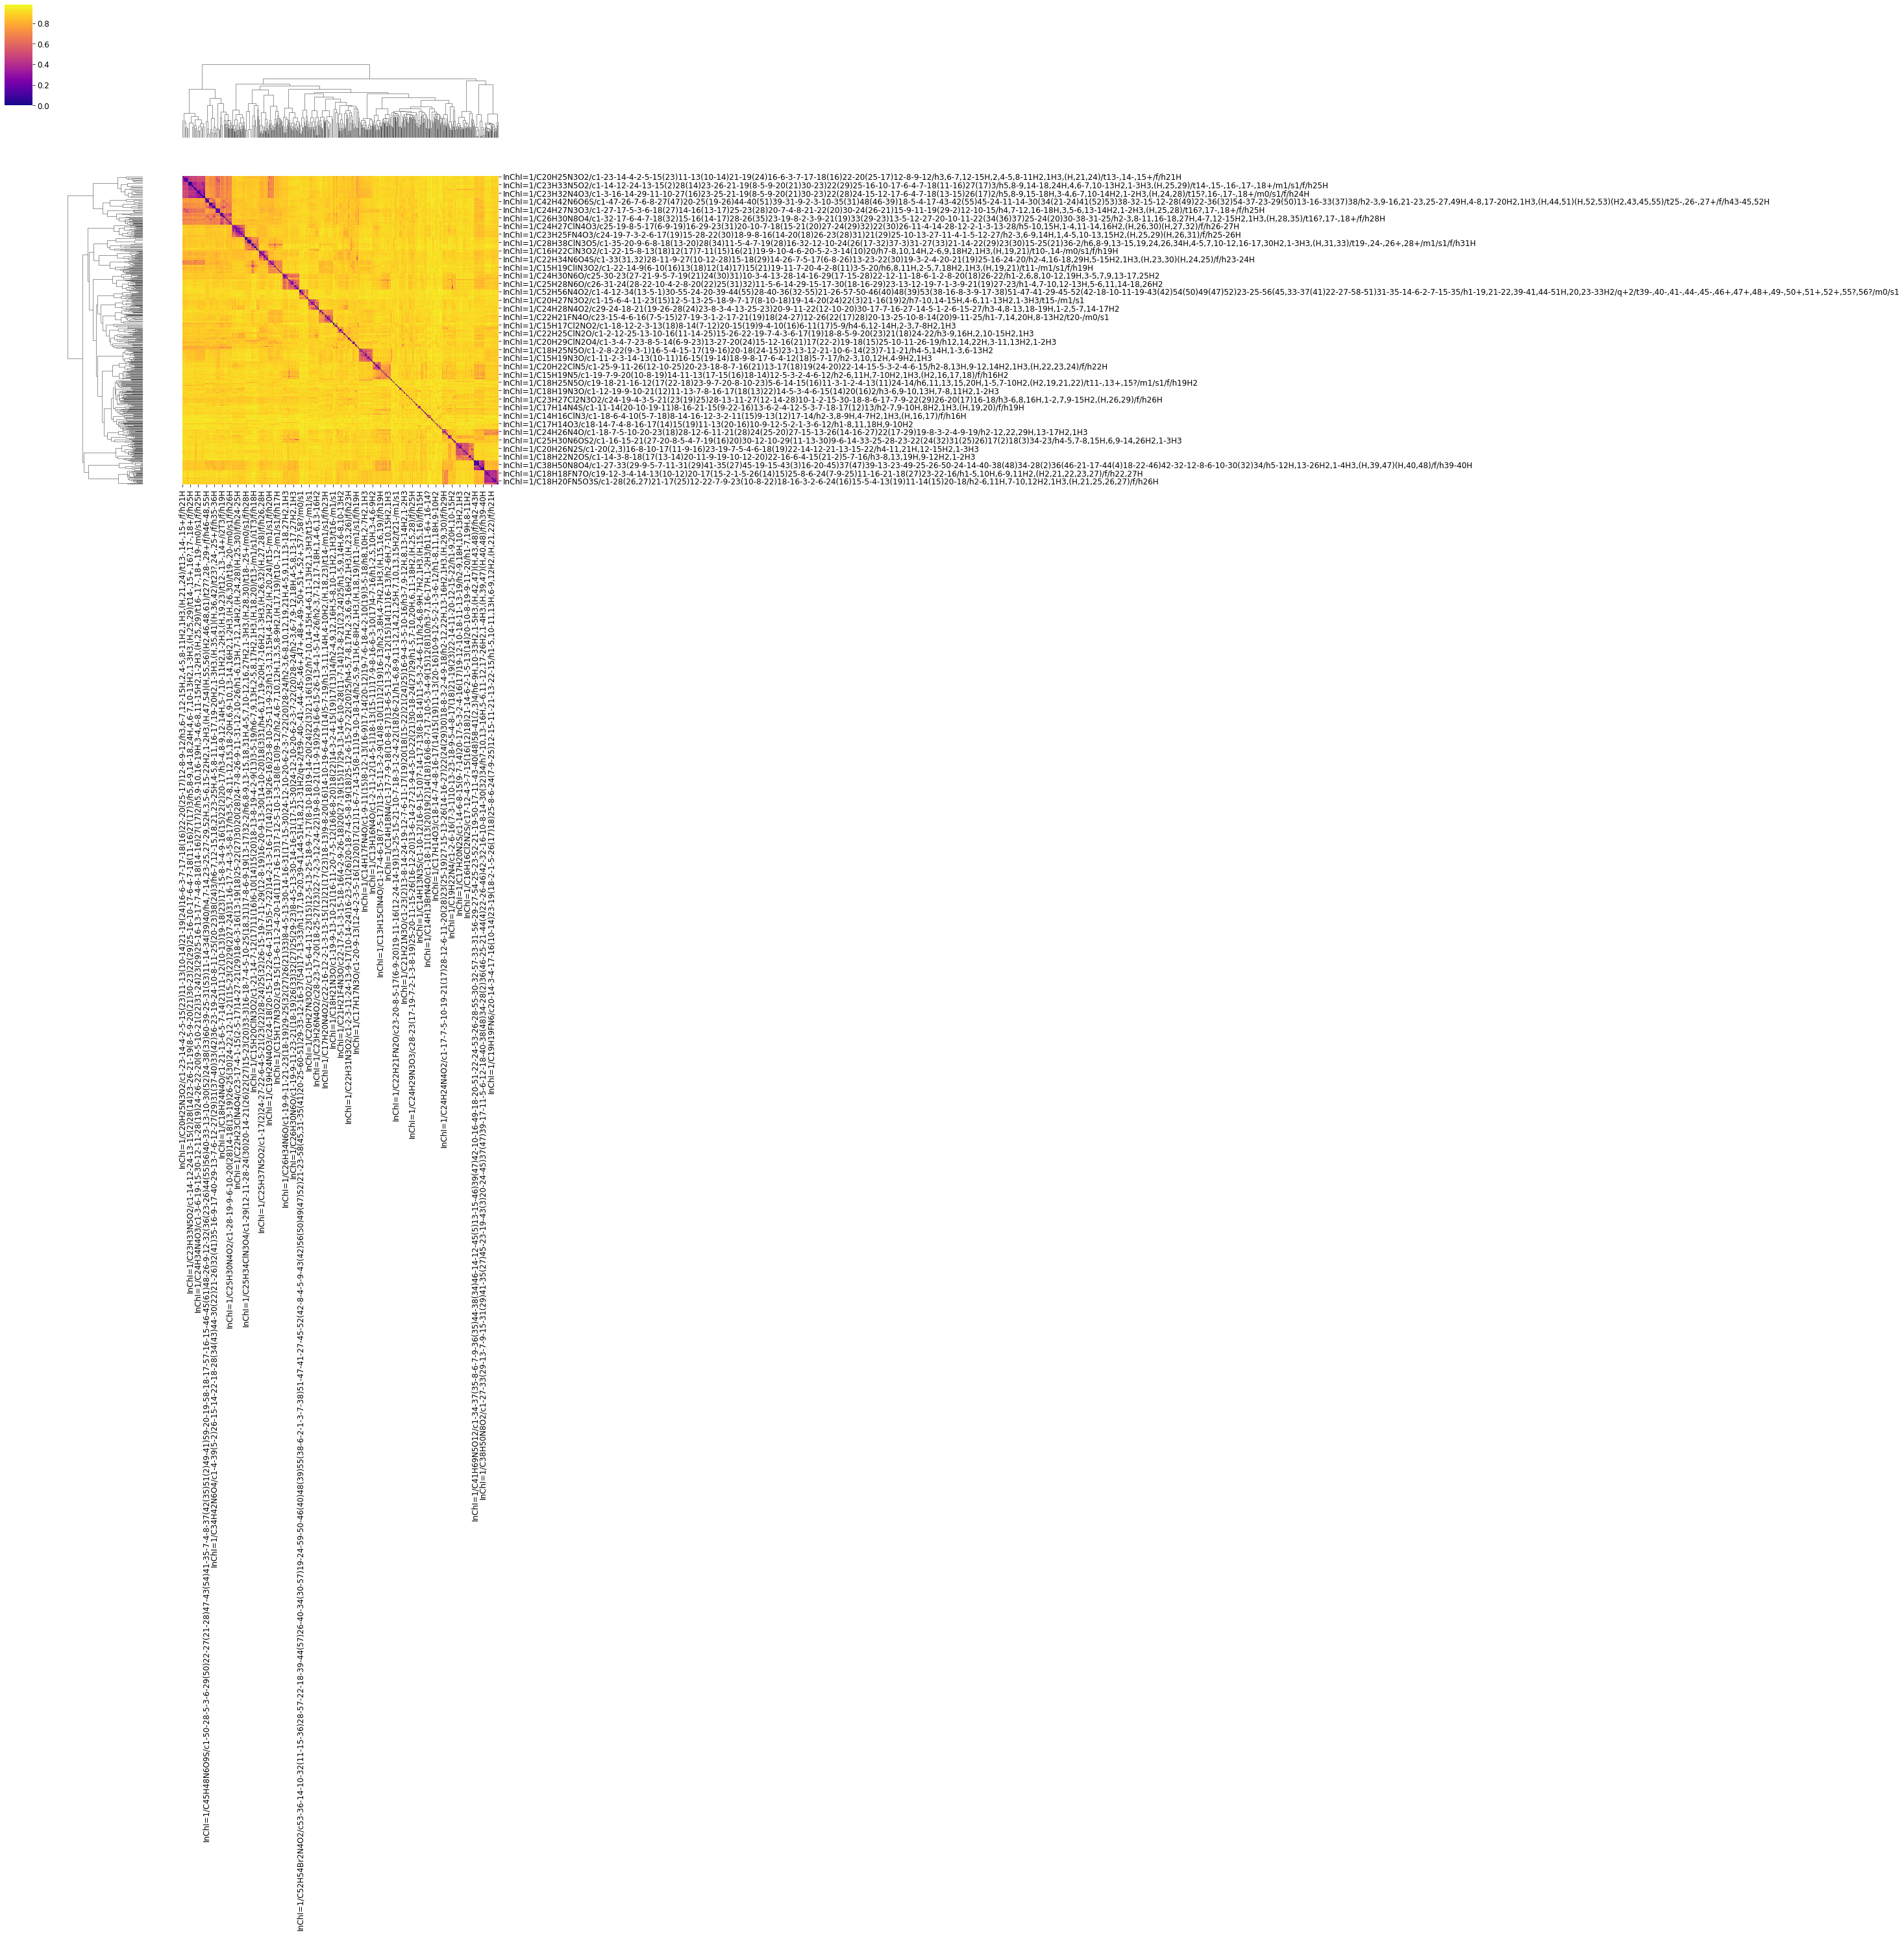

In [35]:
dp.diversity_plots(dset_key=ifile,datastore=False,id_col='InChI',response_col='pXC50')

## Self similarity (Tanimoto) 

Calculate self-similarity (using Tanimoto) for the dataset and plot the distanes. 

In [36]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = save_smiles_df['rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

In [37]:
print(len(dist_sample))
print(len(smiles_lst1))

649
649


## What does **calc_dist_smiles** function return? 


*   input is a list of SMILES strings
*   data featurization: ECFP (Fingerprint)
*   What distance metric to use? Tanimoto
*   How to process distance matrix, nearest ?
*   returns a distance matrix as a vector of distances

Here is the function summary:

*   rdkit is used to transform SMILES to mols
*   mols to FP (Morgan, 1024 FP)
*   calls calc_summary with the following options: 
         * fprints1 is the FP 
         * fprints2 is none 
         * dist_metrics will return a distance matrix
    calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type=nearest, num_nearest=1, within_dset=True)

* Finally, returns the distances of each atom to its closest neighbor 



## Explanation for the following code chunk

* **scipy.stats.kde** will use kernel density function to estimate the probability density function (PDE)
---



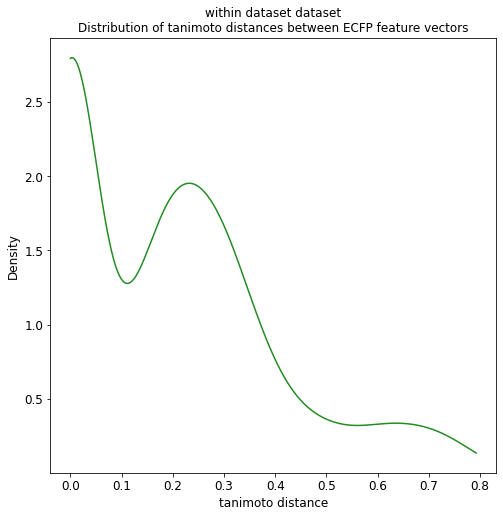

In [38]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [39]:
!date # ending time

Wed Sep 15 15:29:29 UTC 2021
